Loaded 74 MI validation trials.
All files found.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step

[RESULT] MI Validation Accuracy: 0.6000


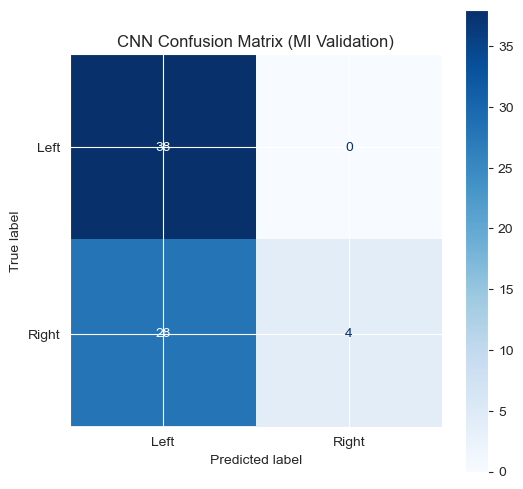

Validation set class counts: {'Left': 38, 'Right': 32}
Predicted class counts: {'Left': 66, 'Right': 4}


In [3]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---- CONFIG ----
validate_dir = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Validate\MI"
channels = ['C3_ref', 'CZ_ref', 'C4_ref']
samples_per_trial = 1750
model_path = r"C:\Users\zezom\PycharmProjects\HorusEye\best_mi_cnn_model.keras"
validation_csv_path = r"C:\Users\zezom\PycharmProjects\HorusEye\validation.csv"

# ---- Load validation metadata ----
val_df = pd.read_csv(validation_csv_path)
mi_labels = ['Left', 'Right']
val_df = val_df[val_df['label'].isin(mi_labels)]
val_df['subject_id'] = val_df['subject_id'].astype(str)
print(f"Loaded {len(val_df)} MI validation trials.")

# ---- Load validation EEG data ----
X_val, y_val = [], []
missing_files = []
for _, row in val_df.iterrows():
    file = f"{row['subject_id']}_{row['trial_session']}_EEGdata_preprocessed.csv"
    file_path = os.path.join(validate_dir, file)
    if not os.path.exists(file_path):
        missing_files.append(file_path)
        continue
    df = pd.read_csv(file_path)
    start = (row['trial'] - 1) * samples_per_trial
    end = row['trial'] * samples_per_trial
    trial_data = df[channels].iloc[start:end].values.T
    if trial_data.shape[1] == samples_per_trial:
        X_val.append(trial_data)
        y_val.append(row['label'])

if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files found.")

X_val = np.array(X_val)
# Per-trial, per-channel Z-score normalization
X_val = (X_val - X_val.mean(axis=-1, keepdims=True)) / (X_val.std(axis=-1, keepdims=True) + 1e-6)

le = LabelEncoder()
le.fit(['Left', 'Right'])
y_val_enc = le.transform(y_val)

# ---- Load model ----
model = load_model(model_path)

# ---- Predict ----
y_pred = np.argmax(model.predict(X_val), axis=1)

# ---- Metrics ----
acc = accuracy_score(y_val_enc, y_pred)
print(f"\n[RESULT] MI Validation Accuracy: {acc:.4f}")

cm = confusion_matrix(y_val_enc, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues')
plt.title("CNN Confusion Matrix (MI Validation)")
plt.show()

# ---- Class distribution ----
unique, counts = np.unique(y_val_enc, return_counts=True)
print("Validation set class counts:", dict(zip(le.classes_, counts)))
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print("Predicted class counts:", dict(zip(le.classes_, counts_pred)))
